## Click Through Rate Prediction Assignment

### Data Loading and Clean-up

In [666]:
#Import required packages


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
import math

import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score


from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MinMaxScaler
import category_encoders as ce


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
import random



sns.set_theme(style="darkgrid")
pd.set_option('display.max_columns', 0)
plt.style.use('ggplot')
pd.options.display.float_format = '{:.2f}'.format


In [667]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [668]:
data = pd.read_csv('data.csv')
data.head()

click    C1  banner_pos   site_id  ... dayofweek day hour  y
0  False  1005           1  856e6d3f  ...         1  28   14  0
1   True  1005           1  e151e245  ...         2  22   19  1
2  False  1005           0  e3c09f3a  ...         3  23   18  0
3  False  1002           0  0da94452  ...         2  22   19  0
4   True  1005           0  1fbe01fe  ...         1  21    8  1

[5 rows x 27 columns]

In [669]:
#month column seem to have same value
data.month.unique()

array([10])

In [670]:
data.click.unique()

array([False,  True])

In [671]:
data.drop(['month'], axis=1,inplace=True)

In [672]:
# size of the dataframe
print('Data Size is - ' + str(data.shape))

Data Size is - (99999, 26)


In [673]:
data.columns

Index(['click', 'C1', 'banner_pos', 'site_id', 'site_domain', 'site_category',
       'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip',
       'device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16',
       'C17', 'C18', 'C19', 'C20', 'C21', 'dayofweek', 'day', 'hour', 'y'],
      dtype='object')

In [674]:
# Let's first check the data for null values
data.isna().sum()

click               0
C1                  0
banner_pos          0
site_id             0
site_domain         0
site_category       0
app_id              0
app_domain          0
app_category        0
device_id           0
device_ip           0
device_model        0
device_type         0
device_conn_type    0
C14                 0
C15                 0
C16                 0
C17                 0
C18                 0
C19                 0
C20                 0
C21                 0
dayofweek           0
day                 0
hour                0
y                   0
dtype: int64

In [675]:
# check for outliers
data.describe()

C1  banner_pos  device_type  ...      day     hour        y
count 99999.00    99999.00     99999.00  ... 99999.00 99999.00 99999.00
mean   1004.97        0.29         1.02  ...    25.49    11.30     0.17
std       1.09        0.51         0.53  ...     2.97     5.94     0.38
min    1001.00        0.00         0.00  ...    21.00     0.00     0.00
25%    1005.00        0.00         1.00  ...    23.00     7.00     0.00
50%    1005.00        0.00         1.00  ...    26.00    11.00     0.00
75%    1005.00        1.00         1.00  ...    28.00    16.00     0.00
max    1012.00        7.00         5.00  ...    30.00    23.00     1.00

[8 rows x 16 columns]

### 1. Perform missing value and outlier treatment, if needed, in the data set you received.
#### Above columns  C15, C16, C19, C21 can have outliers.  Let's plot and cross check it.

In [676]:
#Define the function to plot the box plots
def boxPlotColumns(columns,dataframe) :
    ix, axs = plt.subplots(ncols=len(columns))
    for i, col in enumerate(columns):
        sns.boxplot(data=dataframe[col], ax=axs[i])

    plt.show()



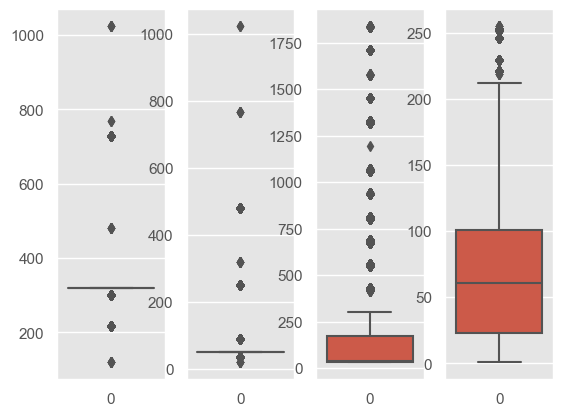

In [677]:
# call the boxPlotColumns function
outlier_columns = ['C15', 'C16', 'C19', 'C21']
boxPlotColumns(outlier_columns,data)

#### These columns do have outliers. Let's cap the values to upper percentile.

In [678]:
# define a function which will take list of colummns and dataframe to cap values
def capOutlierValues(columns, dataframe) :
    for column in columns:
        percentiles = dataframe[column].quantile(0.98)
        if dataframe[column].quantile(0.98) < 0.5 * dataframe[column].max():
            dataframe[column][dataframe[column] >= percentiles] = percentiles
    return dataframe

In [679]:
#call outlier capping function
data = capOutlierValues(outlier_columns, data)

In [680]:
boxPlotColumns(outlier_columns,data)

In [681]:
#

cor = data.corr()
plt.figure(figsize=(15,15))
sns.heatmap(cor, annot=True, cmap="YlGnBu")
plt.show()

#### 
    we have already dropped the month column
    we can see that column 'y' and column 'click' are same so click can be dropeed
    device type and c1 are very highly correlated and thus can be dropped
    

In [682]:
data.drop([ 'device_type', 'click'], axis=1, inplace=True)
data.columns

Index(['C1', 'banner_pos', 'site_id', 'site_domain', 'site_category', 'app_id',
       'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model',
       'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21', 'dayofweek', 'day', 'hour', 'y'],
      dtype='object')

#### This data looks much better now
-----

### 2. Perform categorical variable treatment:

    Identify the categorical columns 
    Use suitable techniques to treat these categorical columns. For instance, as explained earlier, the banner position is a categorical variable. 
#### Let's check the data types

In [683]:
data.dtypes

C1                   int64
banner_pos           int64
site_id             object
site_domain         object
site_category       object
app_id              object
app_domain          object
app_category        object
device_id           object
device_ip           object
device_model        object
device_conn_type     int64
C14                  int64
C15                  int64
C16                  int64
C17                  int64
C18                  int64
C19                  int64
C20                  int64
C21                  int64
dayofweek            int64
day                  int64
hour                 int64
y                    int64
dtype: object

#### We can see that the target column click is a boolean and rest of the datatypes are 
boolean - click

int64 numerical type - C1, banner_pos, device_type, device_conn_type, C14, C15, C16, C17, C18, C19, C20, C21, dayofweek, day, hour, y

object categorical type - site_id, site_domain, app_id, app_domain, app_category, device_id, device_ip, device_model




#### Let's check the unique values in categorical data

In [684]:
data['site_id'].value_counts()

85f751fd    36022
1fbe01fe    15862
e151e245     6597
d9750ee7     2376
5b08c53b     2305
            ...  
9e1b18be        1
27e10723        1
1661bb7f        1
1edf0277        1
bf991633        1
Name: site_id, Length: 1485, dtype: int64

In [685]:
data['site_domain'].value_counts()

c4e18dd6    37362
f3845767    15862
7e091613     8280
7687a86e     3220
98572c79     2456
            ...  
babf5d87        1
a63817ea        1
8d450543        1
66cf2855        1
bde22369        1
Name: site_domain, Length: 1331, dtype: int64

In [686]:
data['app_id'].value_counts()

ecad2386    63977
92f5800b     3865
e2fcccd2     2849
febd1138     1888
9c13b419     1867
            ...  
680d6760        1
a40fbb61        1
82a4d1ff        1
0890d0ba        1
a821a6b6        1
Name: app_id, Length: 1354, dtype: int64

In [687]:
data['app_domain'].value_counts()

7801e8d9    67464
2347f47a    12893
ae637522     4701
5c5a694b     2850
82e27996     1889
            ...  
ead20d3d        1
2619a4f7        1
cb36afb8        1
ae36b8ab        1
63f57be0        1
Name: app_domain, Length: 96, dtype: int64

In [688]:
data['app_category'].value_counts()

07d7df22    64769
0f2161f8    23644
cef3e649     4300
8ded1f7a     3519
f95efa07     2868
d1327cf5      315
dc97ec06      140
09481d60      129
75d80bbe       81
4ce2e9fc       67
fc6fa53d       58
a3c42688       32
879c24eb       22
4681bb9d       21
0f9a328c       13
a86a3e89        6
2281a340        6
8df2e842        5
7113d72a        2
a7fd01ec        1
79f0b860        1
Name: app_category, dtype: int64

In [689]:
data['device_id'].value_counts()

a99f214a    82579
c357dbff       62
0f7c61dc       51
afeffc18       34
936e92fb       27
            ...  
125e25bb        1
244973fb        1
9ba711d4        1
60e04656        1
927c68c6        1
Name: device_id, Length: 16801, dtype: int64

In [690]:
data['device_model'].value_counts()

8a4875bd    6041
1f0bc64f    3401
d787e91b    3373
76dc4769    1862
be6db1d7    1805
            ... 
1dbc394f       1
913bd042       1
1d222263       1
8932b0c5       1
c84e186e       1
Name: device_model, Length: 3145, dtype: int64

#### Based on the observation
    The categorical variable have lots of unique values in it. The one-hot encoding is not suitable in this case.
    We should use label encoding
    "Using one-hot encoding increases the dimensionality of the data set. Label encoding doesn't affect the dimensionality of the data set."

In [691]:
X = data.drop(['y'], axis=1)
y = data['y']

In [692]:
target_encoder = ce.TargetEncoder()
X = target_encoder.fit_transform(X, y)
X

C1  banner_pos  site_id  site_domain  ...  C21  dayofweek  day  hour
0      1005           1     0.03         0.03  ...  221          1   28    14
1      1005           1     0.30         0.26  ...   16          2   22    19
2      1005           0     0.05         0.03  ...   23          3   23    18
3      1002           0     0.00         0.00  ...   23          2   22    19
4      1005           0     0.20         0.20  ...   79          1   21     8
...     ...         ...      ...          ...  ...  ...        ...  ...   ...
99994  1005           0     0.17         0.16  ...   23          3   23    15
99995  1005           0     0.20         0.20  ...  221          2   29     0
99996  1005           0     0.12         0.13  ...   23          2   22    15
99997  1005           0     0.46         0.46  ...   23          5   25     8
99998  1005           0     0.20         0.20  ...   51          1   28     1

[99999 rows x 23 columns]

-----

### 3. Perform a train-test split in the data set (the usual split followed in the industry is 70-30 or 80-20).

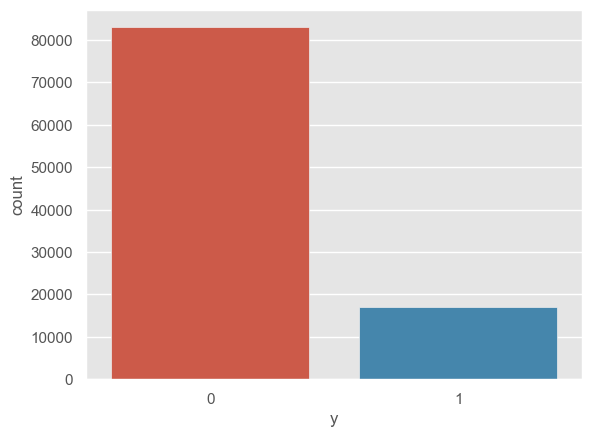

In [693]:
# Let's check if the data is balanced
sns.countplot(x=y)
plt.show()

##### We can clearly see that the data is not balanced. 
    An inbalanced training data could lead to model biased towards the higher number of records present.
    Let's balance the train data

In [694]:
randomsample=  RandomOverSampler()
x_bal, y_bal = randomsample.fit_resample(X, y)


In [695]:
# Plot and check
sns.countplot(x=y_bal)
plt.show()

In [696]:
# Let's Obtain the train test data
X_train, X_test, y_train, y_test = train_test_split(x_bal, y_bal, stratify= y_bal, test_size= 0.3, random_state= 42)

In [697]:
scaler = MinMaxScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_train


C1  banner_pos  site_id  site_domain  ...  C21  dayofweek  day  hour
138890 0.36        0.14     0.30         0.29  ... 0.05       0.50 0.22  0.22
12154  0.36        0.00     0.12         0.14  ... 0.90       0.50 1.00  0.17
16971  0.36        0.00     0.12         0.14  ... 0.87       0.17 0.78  0.48
114504 0.36        0.00     0.12         0.14  ... 0.46       0.17 0.00  0.17
24685  0.36        0.00     0.12         0.14  ... 0.16       0.00 0.67  0.39
...     ...         ...      ...          ...  ...  ...        ...  ...   ...
74935  0.36        0.14     0.05         0.06  ... 0.09       0.00 0.67  0.22
8091   0.36        0.00     0.05         0.11  ... 0.61       0.33 0.11  0.43
36046  0.36        0.00     0.43         0.51  ... 0.13       0.17 0.78  0.04
34280  0.36        0.00     0.12         0.14  ... 0.87       0.17 0.78  0.57
76122  0.36        0.00     0.21         0.23  ... 0.87       0.17 0.78  0.74

[116226 rows x 23 columns]

### 4. Identify the 3 classification methods you will use in the data set, and explain the reason you chose those 3 methods in the notebook file you will share in the submission process.

    we chose below three models and also reason given for these mdoel selection
    1. Logistic Regression - This will help find linear relationship and for better explainability
    2. Decision Tree - This will help find non-linear relationship and for better explainability
    3. Random Forest - This will help find non-linear relationship and for improving model accuracy

#### Let's build these models without  "model simplification techniques like feature creation and selection, to improve model predictability" since this we'll do later and comapare it



#### Functions required for model evaluation, cross validaiton, roc curve plotting and getting evaluation score as a dataframe records

In [698]:
# Function to evaluate the model

def model_evaluation(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    conf_matrix = metrics.confusion_matrix(y_test, y_pred)
    return accuracy, conf_matrix

In [699]:
# Function for cross validation

def cross_val (model, x, y, folds):
    crossvalidation = cross_val_score(model, x, y, cv= folds, n_jobs=-1)
    return crossvalidation

In [700]:
# Function for storing evaluation metrics

def plot_roc(model, Xtest, actual):
    y_test_pred = model.predict(X_test)
    fpr, tpr, thresholds = metrics.roc_curve( actual, y_test_pred,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, y_test_pred )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

In [701]:
# Function to get the evaluation score in a data frame record
def get_eval_score_df_entry(name, y_train, x_train, y_test, x_test, model, folds):
    
    crossvalidation = cross_val(model, x_train, y_train, folds)
    
    accuracy_test, cm1 =  model_evaluation(model, x_train, y_train)
    TP = cm1[1,1] # true positive 
    TN = cm1[0,0] # true negatives
    FP = cm1[0,1] # false positives
    FN = cm1[1,0] # false negatives
    recall_test = TP / (TP+FP)
    precision_test = TP / (TP+FN)
    
    accuracy_train, cm1 =  model_evaluation(model, x_test, y_test)
    TP = cm1[1,1] # true positive 
    TN = cm1[0,0] # true negatives
    FP = cm1[0,1] # false positives
    FN = cm1[1,0] # false negatives
    recall_train = TP / (TP+FP)
    precision_train = TP / (TP+FN)

    entry = {'model_name': [name],
          'accuracy_train': [accuracy_train],
          'recall_train': [recall_train],
          'precision_train': [precision_train],
          'accuracy_test': [accuracy_train],
          'recall_test': [recall_train],
          'precision_test': [precision_train],
          'cross_val_mean': [crossvalidation.mean()],           
          'cross_val_1': [crossvalidation[0]],
          'cross_val_2': [crossvalidation[1]],
          'cross_val_3': [crossvalidation[2]],
          'cross_val_4': [crossvalidation[3]],
          'cross_val_5': [crossvalidation[4]],
          }
    result = pd.DataFrame(entry)
    return result

#### Logistic Regression

In [702]:
lr_model = LogisticRegression(solver='lbfgs', max_iter=1000) 
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

#### While using logistic regression we faced below mentioned error causing to use parameter solver='lbfgs', max_iter=1000
    anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
    STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

    Increase the number of iterations (max_iter) or scale the data as shown in:
        https://scikit-learn.org/stable/modules/preprocessing.html
    Please also refer to the documentation for alternative solver options:
        https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
      extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
    /Users/dineshvhatte/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
    STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.


0.7189231510479402
[[18053  6853]
 [ 7148 17758]]


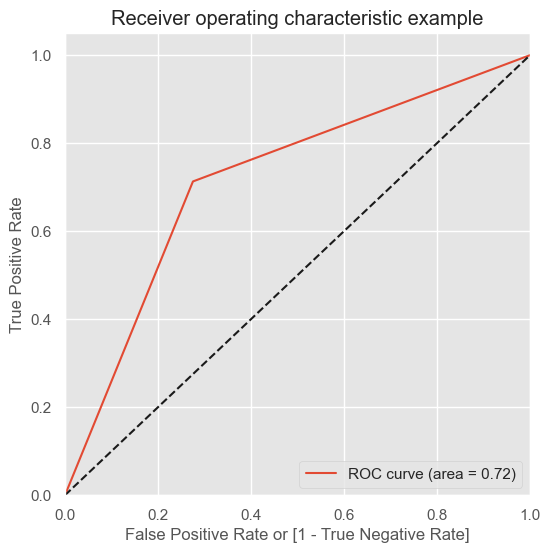

model_name  accuracy_train  ...  cross_val_4  cross_val_5
0  Logistic Regression            0.72  ...         0.72         0.72

[1 rows x 13 columns]

In [703]:
model_eval_scores = pd.DataFrame()
len(X_test)
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])
y_pred = lr_model.predict(X_test)
accuracy, cnf_matrix = model_evaluation(lr_model, X_test, y_test)
print(accuracy)
print(cnf_matrix)
model_eval_df = get_eval_score_df_entry("Logistic Regression", y_train, X_train, y_test, X_test, lr_model, 5)
plot_roc(lr_model, X_test, y_test)
model_eval_scores = model_eval_scores.append(model_eval_df)
model_eval_scores

#### Decision Tree

0.9044406970207982
[[20692  4214]
 [  546 24360]]


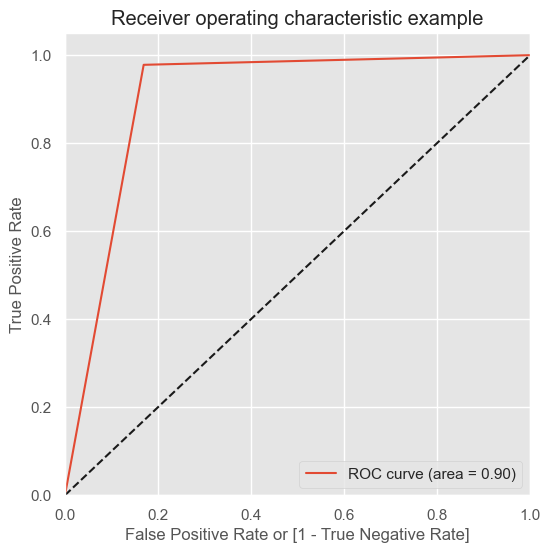

model_name  accuracy_train  ...  cross_val_4  cross_val_5
0  Logistic Regression            0.72  ...         0.72         0.72
0        Decision Tree            0.90  ...         0.88         0.88

[2 rows x 13 columns]

In [704]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_preds = dt_model.predict(X_test)
accuracy, cnf_matrix = model_evaluation(dt_model, X_test, y_test)
print(accuracy)
print(cnf_matrix)
model_eval_df = get_eval_score_df_entry("Decision Tree", y_train, X_train, y_test, X_test, dt_model, 5)
plot_roc(dt_model, X_test, y_test)
model_eval_scores = model_eval_scores.append(model_eval_df)
model_eval_scores


#### Random Forest

0.9218461414920099
[[21473  3433]
 [  460 24446]]


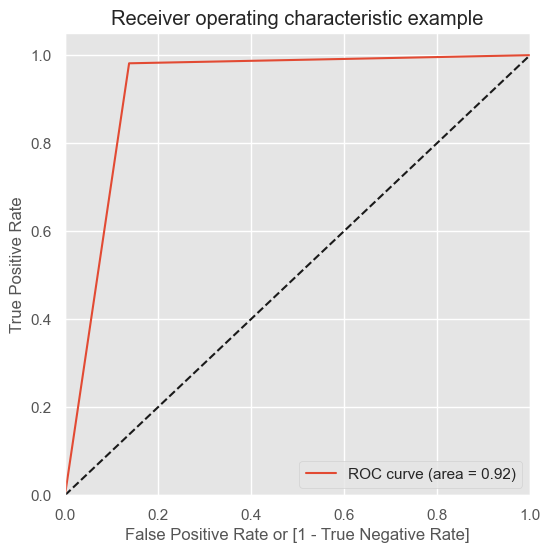

model_name  accuracy_train  ...  cross_val_4  cross_val_5
0  Logistic Regression            0.72  ...         0.72         0.72
0        Decision Tree            0.90  ...         0.88         0.88
0        Random Forest            0.92  ...         0.90         0.90

[3 rows x 13 columns]

In [705]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_preds = rf_model.predict(X_test)
accuracy, cnf_matrix = model_evaluation(rf_model, X_test, y_test)
print(accuracy)
print(cnf_matrix)
model_eval_df = get_eval_score_df_entry("Random Forest", y_train, X_train, y_test, X_test, rf_model, 5)
plot_roc(rf_model, X_test, y_test)
model_eval_scores = model_eval_scores.append(model_eval_df)
model_eval_scores

### From Above observations we can conclude that 
    Random forest performs the best of among all the models selected above with accuracy of 0.92
    Next is descision tree with accuracy score of 0.90. Logistic regression isn't performing very well and has a accuracy score of 0.72
    

### 5. For all 3 methods, use appropriate evaluation metrics to assess model performance. Also, evaluate the models' basis the cross-validation.

#### Models trained and evaluated on the accuracy score, recall, precision and cross validation
    Let's plot the performance

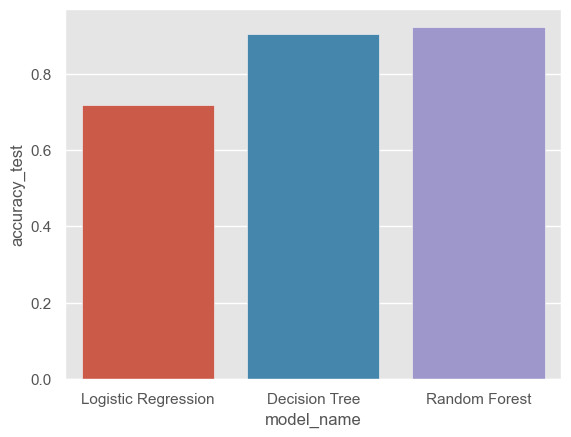

In [706]:
sns.barplot(x="model_name", y="accuracy_test", data=model_eval_scores)
plt.show()

### 6. Compare which methods work best based on the evaluation metrics mentioned in the previous point.

In [707]:
model_eval_scores

model_name  accuracy_train  ...  cross_val_4  cross_val_5
0  Logistic Regression            0.72  ...         0.72         0.72
0        Decision Tree            0.90  ...         0.88         0.88
0        Random Forest            0.92  ...         0.90         0.90

[3 rows x 13 columns]

#### From the metrics and graph above we can conclude that Random Forest performs the best followed by Decision Tree and Logistic Regression. It is best in all accuracy, precision, recall and cross validation as well as can be seen in the metrics above

### 7. Use model simplification techniques like feature creation and selection, to improve model predictability. 

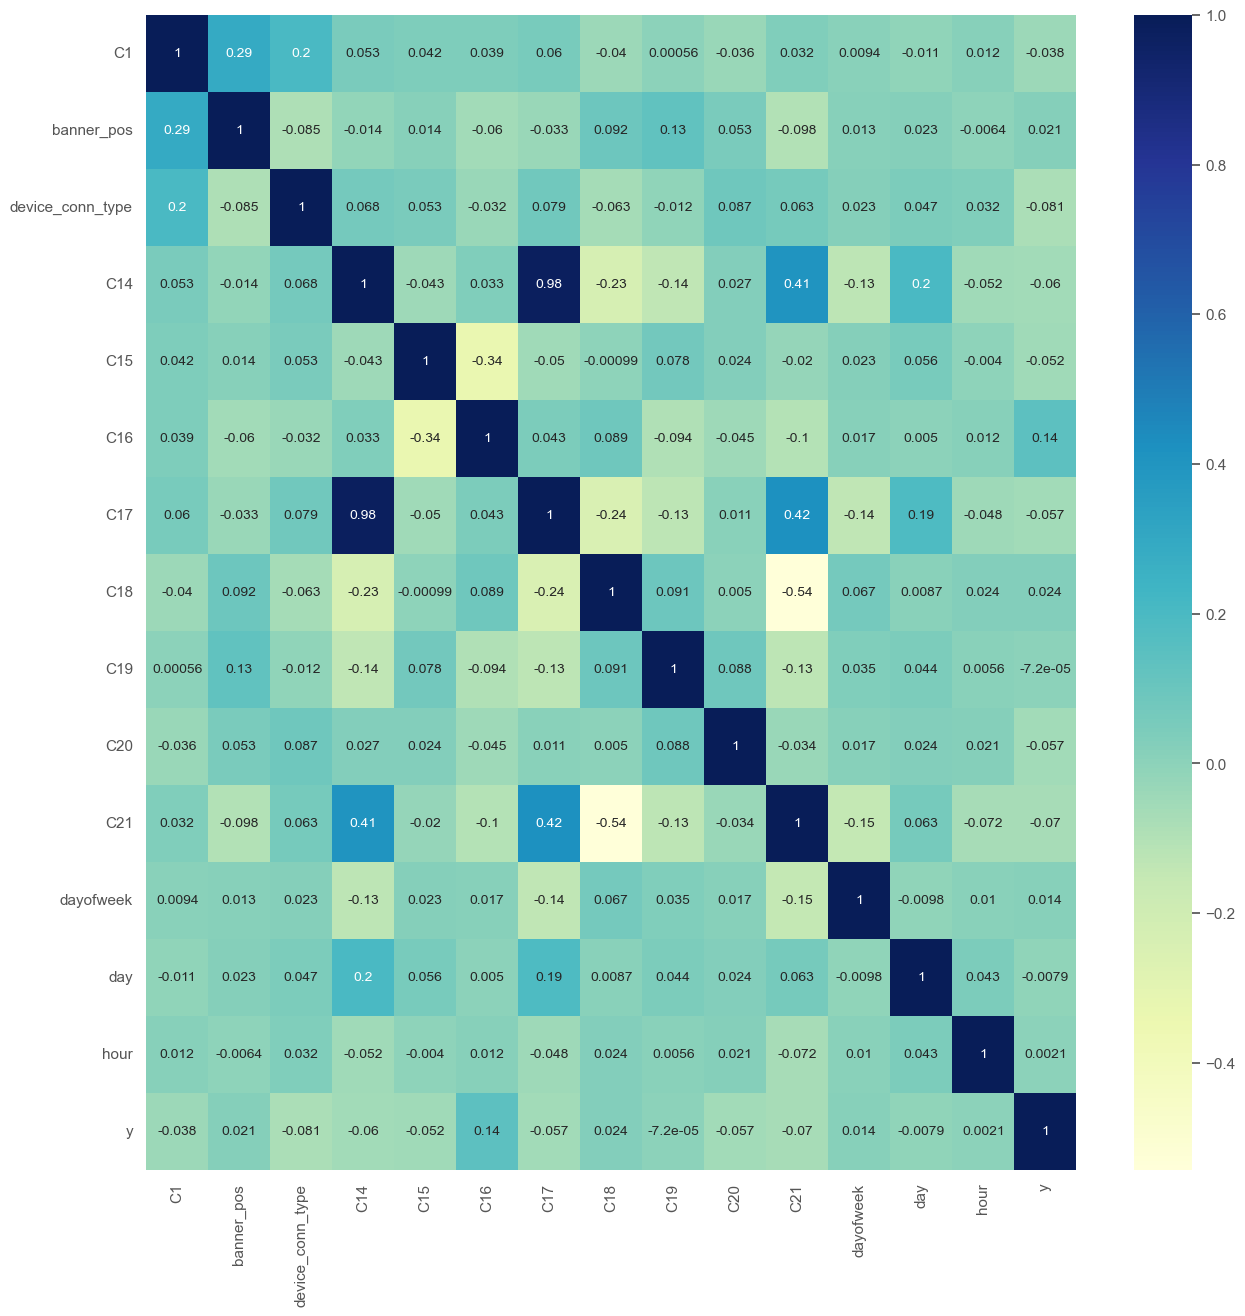

In [708]:
#

cor = data.corr()
plt.figure(figsize=(15,15))
sns.heatmap(cor, annot=True, cmap="YlGnBu")
plt.show()

In [709]:
# we can furhter delete the correlated columns either C17 or C21 
data.drop(['C17'], axis=1, inplace= True)

In [710]:
X = data.drop(['y'], axis=1)
y = data['y']

In [711]:
target_encoder = ce.TargetEncoder()
X = target_encoder.fit_transform(X, y)
X

C1  banner_pos  site_id  site_domain  ...  C21  dayofweek  day  hour
0      1005           1     0.03         0.03  ...  221          1   28    14
1      1005           1     0.30         0.26  ...   16          2   22    19
2      1005           0     0.05         0.03  ...   23          3   23    18
3      1002           0     0.00         0.00  ...   23          2   22    19
4      1005           0     0.20         0.20  ...   79          1   21     8
...     ...         ...      ...          ...  ...  ...        ...  ...   ...
99994  1005           0     0.17         0.16  ...   23          3   23    15
99995  1005           0     0.20         0.20  ...  221          2   29     0
99996  1005           0     0.12         0.13  ...   23          2   22    15
99997  1005           0     0.46         0.46  ...   23          5   25     8
99998  1005           0     0.20         0.20  ...   51          1   28     1

[99999 rows x 22 columns]

In [712]:
randomsample=  RandomOverSampler()
x_new, y_new = randomsample.fit_resample(X, y)

In [713]:
sns.countplot(x=y_new)
plt.show()

In [714]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y_new, stratify= y_new, test_size= 0.3, random_state= 42)

In [715]:
scaler = MinMaxScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_train.head()


C1  banner_pos  site_id  site_domain  ...  C21  dayofweek  day  hour
138890 0.36        0.00     0.12         0.14  ... 0.06       0.33 0.11  0.96
12154  0.36        0.00     0.12         0.14  ... 0.90       0.50 1.00  0.17
16971  0.36        0.00     0.12         0.14  ... 0.87       0.17 0.78  0.48
114504 0.36        0.14     0.27         0.29  ... 0.09       0.33 0.11  0.35
24685  0.36        0.00     0.12         0.14  ... 0.16       0.00 0.67  0.39

[5 rows x 22 columns]

In [716]:
X_train_sm = sm.add_constant(X_train)
logm2 = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:               116226
Model:                            GLM   Df Residuals:                   116203
Model Family:                Binomial   Df Model:                           22
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -62904.
Date:                Tue, 14 Feb 2023   Deviance:                   1.2581e+05
Time:                        21:41:16   Pearson chi2:                 2.15e+05
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2620
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -5.1328      0.182    -28.255      0.000      -5.489      -4.777
C1                   0.5885      0.089      6.595      0.000       0.414       0.763
banner_pos           0.0573      0.117      0.492      0.623      -0.171       0.286
site_id              3.3895      0.167     20.290      0.000       3.062       3.717
site_domain          3.1796      0.168     18.884      0.000       2.850       3.510
site_category       -0.3039      0.123     -2.467      0.014      -0.545      -0.062
app_id               9.9065      0.184     53.840      0.000       9.546      10.267
app_domain          -2.2269      0.155    -14.361      0.000      -2.531      -1.923
app_category        -1.3348      0.062    -21.400      0.000      -1.457      -1.213
device_id            3.0044      0.382      7.874      0.000       2.257       3.752
device_ip            7.8258      0.102     76.494      0.000       7.625       8.026
device_model         4.4191      0.091     48.704      0.000       4.241       4.597
device_conn_type     0.2531      0.055      4.619      0.000       0.146       0.360
C14                 -0.2188      0.035     -6.172      0.000      -0.288      -0.149
C15                  0.5925      0.144      4.104      0.000       0.310       0.875
C16                 -0.5109      0.049    -10.495      0.000      -0.606      -0.415
C18                 -0.0137      0.020     -0.684      0.494      -0.053       0.026
C19                  0.2683      0.035      7.688      0.000       0.200       0.337
C20                  0.1277      0.014      8.979      0.000       0.100       0.156
C21                 -0.0769      0.033     -2.344      0.019      -0.141      -0.013
dayofweek           -0.0186      0.024     -0.766      0.444      -0.066       0.029
day                 -0.0212      0.021     -0.989      0.323      -0.063       0.021
hour                -0.0924      0.027     -3.424      0.001      -0.145      -0.039
====================================================================================
"""

In [717]:
y_train_pred = res.predict(X_train_sm)
y_train_pred_final = pd.DataFrame({'y':y_train, 'y_Prob':y_train_pred})
y_train_pred_final['predicted'] = y_train_pred_final.y_Prob.map(lambda x: 1 if x > 0.5 else 0)
confusion = metrics.confusion_matrix(y_train_pred_final.y, y_train_pred_final.predicted )
print(confusion)
print(metrics.accuracy_score(y_train_pred_final.y, y_train_pred_final.predicted))

[[42165 15948]
 [16654 41459]]
0.7194947774164129


In [718]:
def sm_model_evaluation (model, x_test, y_test):
    X_sm = sm.add_constant(x_test)
    y_pred = res.predict(X_sm)
    y_train_pred_final = pd.DataFrame({'y':y_test, 'y_Prob':y_pred})
    y_train_pred_final['predicted'] = y_train_pred_final.y_Prob.map(lambda x: 1 if x > 0.5 else 0)
    # Let's check the overall accuracy.
    print(metrics.accuracy_score(y_train_pred_final.y, y_train_pred_final.predicted))
    confusion = metrics.confusion_matrix(y_train_pred_final.y, y_train_pred_final.predicted )
    print(confusion)

In [719]:
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])
sm_model_evaluation(res, X_test, y_test)  

0.7198466233036216
[[18043  6863]
 [ 7092 17814]]


In [720]:
vif = pd.DataFrame()
vif['Features'] = X_train_sm.columns
vif['VIF'] = [variance_inflation_factor(X_train_sm.values, i) for i in range(X_train_sm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
0              const 582.05
3            site_id   6.55
4        site_domain   6.51
8       app_category   2.04
15               C16   2.03
5      site_category   1.97
7         app_domain   1.91
19               C21   1.76
6             app_id   1.63
16               C18   1.62
1                 C1   1.42
2         banner_pos   1.34
13               C14   1.32
11      device_model   1.30
12  device_conn_type   1.30
9          device_id   1.30
14               C15   1.25
17               C19   1.09
10         device_ip   1.08
18               C20   1.08
21               day   1.06
20         dayofweek   1.04
22              hour   1.02

    We can see that the VIF values are good considering the p value in above metrics. 
    We can remove hour, day and dayof week

In [721]:
X_train_sm.drop(['hour','day', 'dayofweek'], axis=1, inplace= True)
logm2 = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:               116226
Model:                            GLM   Df Residuals:                   116206
Model Family:                Binomial   Df Model:                           19
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -62911.
Date:                Tue, 14 Feb 2023   Deviance:                   1.2582e+05
Time:                        21:41:25   Pearson chi2:                 2.12e+05
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2619
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -5.1848      0.181    -28.689      0.000      -5.539      -4.831
C1                   0.5762      0.089      6.465      0.000       0.402       0.751
banner_pos           0.0578      0.116      0.496      0.620      -0.170       0.286
site_id              3.3745      0.167     20.220      0.000       3.047       3.702
site_domain          3.1782      0.168     18.887      0.000       2.848       3.508
site_category       -0.3001      0.123     -2.439      0.015      -0.541      -0.059
app_id               9.8872      0.184     53.787      0.000       9.527      10.247
app_domain          -2.1879      0.155    -14.150      0.000      -2.491      -1.885
app_category        -1.3409      0.062    -21.547      0.000      -1.463      -1.219
device_id            3.0065      0.381      7.887      0.000       2.259       3.754
device_ip            7.8246      0.102     76.507      0.000       7.624       8.025
device_model         4.4153      0.091     48.689      0.000       4.238       4.593
device_conn_type     0.2501      0.055      4.568      0.000       0.143       0.357
C14                 -0.2188      0.035     -6.335      0.000      -0.286      -0.151
C15                  0.5818      0.144      4.044      0.000       0.300       0.864
C16                 -0.5082      0.049    -10.446      0.000      -0.604      -0.413
C18                 -0.0148      0.020     -0.739      0.460      -0.054       0.024
C19                  0.2668      0.035      7.652      0.000       0.198       0.335
C20                  0.1271      0.014      8.934      0.000       0.099       0.155
C21                 -0.0694      0.033     -2.126      0.034      -0.133      -0.005
====================================================================================
"""

#### Let's recheck VIF

In [722]:
vif = pd.DataFrame()
vif['Features'] = X_train_sm.columns
vif['VIF'] = [variance_inflation_factor(X_train_sm.values, i) for i in range(X_train_sm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif


Features    VIF
0              const 574.28
3            site_id   6.55
4        site_domain   6.51
8       app_category   2.04
15               C16   2.03
5      site_category   1.97
7         app_domain   1.89
19               C21   1.74
6             app_id   1.63
16               C18   1.62
1                 C1   1.42
2         banner_pos   1.34
11      device_model   1.30
9          device_id   1.29
12  device_conn_type   1.29
13               C14   1.26
14               C15   1.25
17               C19   1.09
18               C20   1.08
10         device_ip   1.08

In [723]:
X_train_sm.drop(['device_ip', 'C15'], axis=1, inplace= True)
logm2 = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:               116226
Model:                            GLM   Df Residuals:                   116208
Model Family:                Binomial   Df Model:                           17
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -67440.
Date:                Tue, 14 Feb 2023   Deviance:                   1.3488e+05
Time:                        21:41:29   Pearson chi2:                 1.42e+05
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2021
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -3.7603      0.114    -32.953      0.000      -3.984      -3.537
C1                   0.8523      0.086      9.896      0.000       0.684       1.021
banner_pos          -0.2281      0.113     -2.026      0.043      -0.449      -0.007
site_id              4.2861      0.164     26.056      0.000       3.964       4.608
site_domain          2.6924      0.164     16.382      0.000       2.370       3.015
site_category       -0.1888      0.119     -1.591      0.112      -0.421       0.044
app_id              10.1489      0.179     56.692      0.000       9.798      10.500
app_domain          -1.9884      0.151    -13.206      0.000      -2.283      -1.693
app_category        -1.3978      0.060    -23.165      0.000      -1.516      -1.280
device_id            4.9327      0.433     11.402      0.000       4.085       5.781
device_model         4.8726      0.088     55.154      0.000       4.699       5.046
device_conn_type     0.1577      0.053      2.976      0.003       0.054       0.262
C14                 -0.2131      0.034     -6.343      0.000      -0.279      -0.147
C16                 -0.6834      0.046    -14.903      0.000      -0.773      -0.593
C18                 -0.0912      0.019     -4.744      0.000      -0.129      -0.054
C19                  0.2212      0.033      6.615      0.000       0.156       0.287
C20                  0.0117      0.014      0.857      0.392      -0.015       0.038
C21                 -0.1488      0.031     -4.749      0.000      -0.210      -0.087
====================================================================================
"""

In [724]:
vif = pd.DataFrame()
vif['Features'] = X_train_sm.columns
vif['VIF'] = [variance_inflation_factor(X_train_sm.values, i) for i in range(X_train_sm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
0              const 114.24
3            site_id   6.53
4        site_domain   6.50
8       app_category   2.03
5      site_category   1.97
7         app_domain   1.89
13               C16   1.82
17               C21   1.74
6             app_id   1.62
14               C18   1.61
1                 C1   1.41
2         banner_pos   1.33
11  device_conn_type   1.29
9          device_id   1.29
10      device_model   1.28
12               C14   1.26
15               C19   1.09
16               C20   1.07

#### Now the parameters look good.
    

In [725]:


y_train_pred = res.predict(X_train_sm)
y_train_pred_final = pd.DataFrame({'y':y_train, 'y_Prob':y_train_pred})
y_train_pred_final['predicted'] = y_train_pred_final.y_Prob.map(lambda x: 1 if x > 0.5 else 0)
confusion = metrics.confusion_matrix(y_train_pred_final.y, y_train_pred_final.predicted )
print(confusion)
print(metrics.accuracy_score(y_train_pred_final.y, y_train_pred_final.predicted))



[[38153 19960]
 [16218 41895]]
0.6887271350644434


In [726]:


col = list(X_train_sm.columns)
col.remove('const')
sm_model_evaluation(res, X_test[col], y_test)  



0.6934875130490645
[[16477  8429]
 [ 6839 18067]]


In [727]:


numbers = [float(x)/20 for x in range(20)]
print(numbers)
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.y_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()



[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]


y  y_Prob  predicted  0.0  0.05  0.1  ...  0.7  0.75  0.8  0.85  0.9  0.95
138890  1    0.57          1    1     1    1  ...    0     0    0     0    0     0
12154   0    0.38          0    1     1    1  ...    0     0    0     0    0     0
16971   0    0.40          0    1     1    1  ...    0     0    0     0    0     0
114504  1    0.63          1    1     1    1  ...    0     0    0     0    0     0
24685   0    0.31          0    1     1    1  ...    0     0    0     0    0     0

[5 rows x 23 columns]

In [728]:
cutoff_df = pd.DataFrame( columns = ['Thresold_prob','accuracy','recall','precision'])
from sklearn.metrics import confusion_matrix

num = [0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.y, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    TP = cm1[1,1] # true positive 
    TN = cm1[0,0] # true negatives
    FP = cm1[0,1] # false positives
    FN = cm1[1,0] # false negatives
    accuracy = (TP + TN)/total1
    
    recall = TP / (TP+FP)
    precision = TP / (TP+FN)
    cutoff_df.loc[i] =[ i ,accuracy,recall,precision]
cutoff_df

Thresold_prob  accuracy  recall  precision
0.00           0.00      0.50    0.50       1.00
0.05           0.05      0.50    0.50       1.00
0.10           0.10      0.51    0.51       1.00
0.15           0.15      0.56    0.53       0.99
0.20           0.20      0.60    0.56       0.97
0.25           0.25      0.63    0.58       0.96
0.30           0.30      0.65    0.60       0.93
0.35           0.35      0.67    0.62       0.89
0.40           0.40      0.68    0.64       0.85
0.45           0.45      0.69    0.65       0.80
0.50           0.50      0.69    0.68       0.72
0.55           0.55      0.68    0.70       0.62
0.60           0.60      0.66    0.73       0.51
0.65           0.65      0.64    0.76       0.41
0.70           0.70      0.61    0.80       0.31
0.75           0.75      0.59    0.82       0.24
0.80           0.80      0.57    0.85       0.16
0.85           0.85      0.55    0.88       0.11
0.90           0.90      0.53    0.91       0.07
0.95           0.95      0.52    0.93       0.04

In [729]:
cutoff_df.plot.line(x='Thresold_prob', y=['accuracy','recall','precision'])
plt.show()

#### To get good accuracy, recall and precision the cut off value is around 0.5

In [730]:
y_train_pred_final['final_predicted'] = y_train_pred_final.y_Prob.map( lambda x: 1 if x > 0.50 else 0)
y_train_pred_final.head()

y  y_Prob  predicted  0.0  0.05  ...  0.8  0.85  0.9  0.95  final_predicted
138890  1    0.57          1    1     1  ...    0     0    0     0                1
12154   0    0.38          0    1     1  ...    0     0    0     0                0
16971   0    0.40          0    1     1  ...    0     0    0     0                0
114504  1    0.63          1    1     1  ...    0     0    0     0                1
24685   0    0.31          0    1     1  ...    0     0    0     0                0

[5 rows x 24 columns]

In [731]:
X_train_sm.drop('const', axis= 1, inplace= True)
X_test = X_test[X_train_sm.columns]
print(X_train_sm.shape)
print(X_test.shape)

(116226, 17)
(49812, 17)


#### Logistic Regression with Feature Engineering

In [732]:
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train_sm, y_train)
accuracy, cnf_matrix = model_evaluation(model, X_test[X_train_sm.columns], y_test)
model_eval_df = get_eval_score_df_entry("logistic reg with feature engine", y_train, X_train_sm, y_test, X_test[X_train_sm.columns],
                     model, 5)
plot_roc(model, X_test[X_train_sm.columns], y_test)
model_eval_scores = model_eval_scores.append(model_eval_df)
model_eval_scores

model_name  accuracy_train  ...  cross_val_4  cross_val_5
0               Logistic Regression            0.72  ...         0.72         0.72
0                     Decision Tree            0.90  ...         0.88         0.88
0                     Random Forest            0.92  ...         0.90         0.90
0  logistic reg with feature engine            0.69  ...         0.69         0.69

[4 rows x 13 columns]

#### Decision Tree with Feature Engineering

In [733]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y_new, stratify= y_new, test_size= 0.3, random_state= 42)
X_train.head(2)

C1  banner_pos  site_id  site_domain  ...  C21  dayofweek  day  hour
138890  1005           0     0.12         0.13  ...   15          2   22    22
12154   1005           0     0.12         0.13  ...  229          3   30     4

[2 rows x 22 columns]

In [734]:
dt_tree = DecisionTreeClassifier(random_state=42)
dt_tree.fit(X_train, y_train)
feature_importances = dt_tree.feature_importances_
features = X_train.columns
df = pd.DataFrame({'features': features, 'importance': feature_importances})
df.sort_values(by='importance', ascending = False)

features  importance
10      device_model        0.16
9          device_ip        0.16
21              hour        0.14
2            site_id        0.13
12               C14        0.10
5             app_id        0.06
20               day        0.05
17               C20        0.05
19         dayofweek        0.04
16               C19        0.02
3        site_domain        0.02
18               C21        0.02
15               C18        0.01
11  device_conn_type        0.01
4      site_category        0.01
1         banner_pos        0.01
6         app_domain        0.00
7       app_category        0.00
8          device_id        0.00
0                 C1        0.00
13               C15        0.00
14               C16        0.00

In [735]:
#### Filter features with significant feature importance
df = df[df.importance > 0.02]
rf_cols = []
for col in list(X_train.columns):
    if col in list(df.features):
        rf_cols.append(col)

rf_cols

['site_id',
 'site_domain',
 'app_id',
 'device_ip',
 'device_model',
 'C14',
 'C19',
 'C20',
 'dayofweek',
 'day',
 'hour']

In [736]:
#### Decision Tree
dt_tree = DecisionTreeClassifier(random_state=42)
dt_tree.fit(X_train[rf_cols], y_train)

DecisionTreeClassifier(random_state=42)

In [737]:
print(rf_cols)
X_train = X_train[rf_cols]
X_test = X_test[rf_cols]
print(len(rf_cols))
predict_rf = dt_tree.predict(X_train)
predict_rf_test = dt_tree.predict(X_test)

['site_id', 'site_domain', 'app_id', 'device_ip', 'device_model', 'C14', 'C19', 'C20', 'dayofweek', 'day', 'hour']
11


In [738]:
accuracy, cnf_matrix = model_evaluation(dt_tree, X_train, y_train)
print("Metrics for Train results")
print("accuracy",accuracy)
print("cnf_matrix \n",cnf_matrix)


Metrics for Train results
accuracy 0.9951645931203001
cnf_matrix 
 [[57641   472]
 [   90 58023]]


In [739]:
accuracy, cnf_matrix = model_evaluation(dt_tree, X_test, y_test)
print("Metrics for Test results")
print("accuracy",accuracy)
print("cnf_matrix \n",cnf_matrix)

Metrics for Test results
accuracy 0.9035573757327552
cnf_matrix 
 [[20660  4246]
 [  558 24348]]


In [740]:
# Plot the ROC Curve
plot_roc(dt_tree, X_test, y_test)

(array([0.        , 0.17048101, 1.        ]),
 array([0.        , 0.97759576, 1.        ]),
 array([2, 1, 0]))

#### Above metrics show that the Decision Tree is overfitting. We can take a look at hyperparameter tuning
    We can make use of grid search cross validation for finding best hyperparameters

In [741]:
param_grid = {
    'max_depth': range(1,15),
    'min_samples_leaf': range(10,200,20),
    'min_samples_split': range(50, 150, 50)
    
}
n_folds = 5
dt_model_gs = DecisionTreeClassifier(random_state= 42)
dt_est_model = GridSearchCV(dt_model_gs, param_grid, cv=n_folds, n_jobs =-1,return_train_score=True)
dt_est_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(1, 15),
                         'min_samples_leaf': range(10, 200, 20),
                         'min_samples_split': range(50, 150, 50)},
             return_train_score=True)

In [742]:
# Print best parameters and estimators

In [743]:
dt_est_model.best_params_

{'max_depth': 14, 'min_samples_leaf': 10, 'min_samples_split': 50}

In [744]:
dt_est_model.best_estimator_

DecisionTreeClassifier(max_depth=14, min_samples_leaf=10, min_samples_split=50,
                       random_state=42)

#### Decision Tree with tued best hyperparameters

In [745]:
dt_model_new =  DecisionTreeClassifier(max_depth=14, min_samples_leaf=10, min_samples_split=50,
                       random_state=42)
dt_model_new.fit(X_train, y_train)
accuracy, cnf_matrix = model_evaluation(dt_model_new, X_test, y_test)
model_eval_df = get_eval_score_df_entry("Decision Tree - Feature Engineering and Hyperparameter Tuning", y_train, X_train, y_test, X_test, \
                     dt_tree, 5)
plot_roc(dt_model_new, X_test, y_test)
model_eval_scores = model_eval_scores.append(model_eval_df)
model_eval_scores

model_name  ...  cross_val_5
0                                Logistic Regression  ...         0.72
0                                      Decision Tree  ...         0.88
0                                      Random Forest  ...         0.90
0                   logistic reg with feature engine  ...         0.69
0  Decision Tree - Feature Engineering and Hyperp...  ...         0.88

[5 rows x 13 columns]

#### Random Forest with Feature Engineering

In [746]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y_new, stratify= y_new, test_size= 0.3, random_state= 42)
X_train.head(2)

C1  banner_pos  site_id  site_domain  ...  C21  dayofweek  day  hour
138890  1005           0     0.12         0.13  ...   15          2   22    22
12154   1005           0     0.12         0.13  ...  229          3   30     4

[2 rows x 22 columns]

In [747]:
rf_model_fe = RandomForestClassifier(random_state=42)
rf_model_fe.fit(X_train, y_train)
feature_importances = rf_model_fe.feature_importances_
features = X_train.columns
df = pd.DataFrame({'features': features, 'importance': feature_importances})
df.sort_values(by='importance', ascending = False)

features  importance
10      device_model        0.19
21              hour        0.14
9          device_ip        0.14
12               C14        0.09
2            site_id        0.08
3        site_domain        0.05
5             app_id        0.05
17               C20        0.05
20               day        0.04
19         dayofweek        0.04
16               C19        0.02
18               C21        0.02
6         app_domain        0.01
11  device_conn_type        0.01
7       app_category        0.01
15               C18        0.01
4      site_category        0.01
8          device_id        0.01
14               C16        0.01
1         banner_pos        0.01
13               C15        0.00
0                 C1        0.00

In [748]:
#### Filter features with significant feature importance
df = df[df.importance > 0.02]
rf_cols = []
for col in list(X_train.columns):
    if col in list(df.features):
        rf_cols.append(col)

rf_cols

['site_id',
 'site_domain',
 'app_id',
 'device_ip',
 'device_model',
 'C14',
 'C19',
 'C20',
 'C21',
 'dayofweek',
 'day',
 'hour']

In [749]:
X_train = X_train[rf_cols]
X_test = X_test[rf_cols]

#### Use these features and build the Random Forest Classifier Model

Train results
accuracy 0.9951559891934679
cnf_matrix 
 [[57622   491]
 [   72 58041]]
Test results
accuracy 0.9205412350437645
cnf_matrix 
 [[21459  3447]
 [  511 24395]]


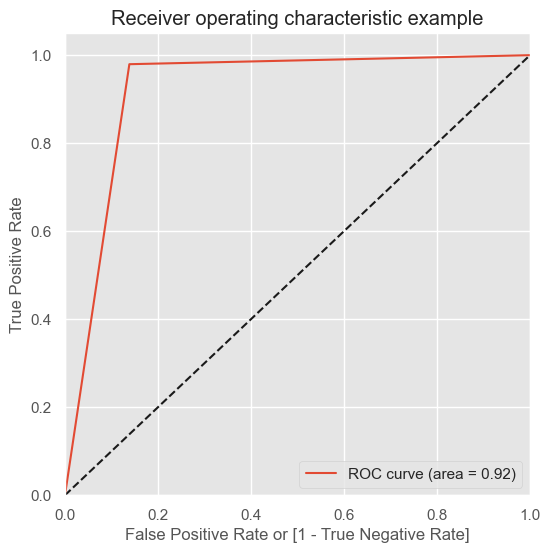

(array([0.        , 0.13840039, 1.        ]),
 array([0.        , 0.97948286, 1.        ]),
 array([2, 1, 0]))

In [750]:
rf_model_new = RandomForestClassifier(random_state=42)
rf_model_new.fit(X_train, y_train)

predict_rf = rf_model_new.predict(X_train)
predict_rf_test = rf_model_new.predict(X_test)

accuracy, cnf_matrix = model_evaluation(rf_model_new, X_train, y_train)
print("Train results")
print("accuracy",accuracy)
print("cnf_matrix \n", cnf_matrix)

accuracy, cnf_matrix = model_evaluation(rf_model_new, X_test, y_test)
print("Test results")
print("accuracy",accuracy)
print("cnf_matrix \n", cnf_matrix)

model_eval_df = get_eval_score_df_entry("Random Forest -  Feature Engineering", y_train, X_train, y_test, X_test, rf_model_new, 5)
model_eval_scores = model_eval_scores.append(model_eval_df)

plot_roc(rf_model_new, X_test, y_test)

In [751]:
model_eval_scores

model_name  ...  cross_val_5
0                                Logistic Regression  ...         0.72
0                                      Decision Tree  ...         0.88
0                                      Random Forest  ...         0.90
0                   logistic reg with feature engine  ...         0.69
0  Decision Tree - Feature Engineering and Hyperp...  ...         0.88
0               Random Forest -  Feature Engineering  ...         0.90

[6 rows x 13 columns]

### 8. After building the best model possible, explain the risks associated with adopting the model to the business team (You can create a 3-5 slide presentation)

    Interpret the evaluation metric of choice 
    Explain the implications of errors made in the prediction by the model.

In [755]:
plt.xticks(rotation=90)
sns.barplot(x="model_name", y="accuracy_test", data=model_eval_scores)
plt.show()

    From the metrics we can see that among all the modesl the Random Forest is the best performing classifier. 
    Although Random Forest with Feaure Enginnering and without feature engineering may apear to be performing the same but
    the random forest classifier with feaures engineering is best fitted for both training and test data.
    
    Decision Tree and Logistic Regression are performing with comparatively low accuracy, precision, recall and in cross validaiton.
    Hence it is reccomended that in this use case the random classifier should be used to get more accurate results. Business can rely on the prediction made by random forest. 
    Below are the most important features that can influence the click through rate
    ['site_id',
     'site_domain',
     'app_id',
     'device_ip',
     'device_model',
     'C14',
     'C19',
     'C20',
     'C21',
     'dayofweek',
     'day',
     'hour']
     
    Business should be careful in choosing the site and it's domain. An advertisement click through could very much be affected by the kind of content on the website that the user is looking at. The kind of advertisement should be put based on the device model. Imagine showing advertisement of a very high cost product on a very simple and low cost device model. The user of such device may not be interest to buying expensive or luxury items
    
    It is also observed that the hours including daysofweek and day are also contributing to important feature for click throught rate. Business can take into account target audience schedule to place the advertisement to have better click through rate.
    
    Above all, when business can provide the input for the most significant features we have model which will predict the click through rate with 92% accuracy
    
    It will help business to target the advertisement to maximize the click through rate.

#### Also please refer to attached slide presentation

-------------------------------------- Completed -------------------------------------